# Test on Controllability and Robustness in Knowledge Graph

- First "pretrain" on pure facts (context length/number of context examples 0) 
- Then "finetune" on 1/3 facts, 1/3 counterfactual, 1/3 robustness (context length ranges from 1 to 3 randomly)
- Test on counterfactual w/ context length 1,2,3, robustness w/ context length 1,2,3

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers


## Config

In [4]:
args = argparse.Namespace(
    batch_size=32, n_epochs=40, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=2, n_heads=4, d_model=128, dff=None)

In [5]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Load Data

In [6]:
# how to load data and createe data loader
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)


In [8]:
# create vocab
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_map = {word: idx for idx, word in enumerate(vocab)}

In [26]:
# some examples from train__ds_tensor
for x in train_ds_tensor:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    break

[55, 56, 58, 4, 51, 32, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N4 R1 N32 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [124]:
# some examples from train_dl
train_iter = iter(train_dl)
for _ in range(5):
    # get next from train_dl
    x, y = next(train_iter)
    x, y = x.squeeze(), y.squeeze()
    print('INPUT')
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print('TARGET')
    print(y.tolist())
    print(' '.join([vocab[idx] for idx in y]))
    print('-'*100)
    print()

INPUT
[15, 16, 18, 2, 11, 7, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
<CTX> </CTX> <QUERY> N2 R1 N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[16, 18, 2, 11, 7, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
</CTX> <QUERY> N2 R1 N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[15, 2, 11, 6, 17, 16, 18, 5, 12, 7, 19, 20, 21, 21, 21, 21, 21, 21, 21]
<CTX> N2 R1 N6 <SEP> </CTX> <QUERY> N5 R2 N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[2, 11, 6, 17, 16, 18, 5, 12, 7, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21]
N2 R1 N6 <SEP> </CTX> <QUERY> N5 R2 N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[15, 2, 14, 9, 17, 0, 10, 9, 17, 16, 18, 3

### Create Val and Test Dataset & DataLoader

In [27]:
vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) 
seq_len = len(train_ds_tensor[0])
print('seq_len: ', seq_len)

# load data and createe data loader

# training set
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)


# pretraining set
train_ds_fact_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds_fact.pt')
train_ds_fact = LanguageModelTensorDataset(train_ds_fact_tensor)
train_dl_fact = torch.utils.data.DataLoader(train_ds_fact, batch_size=args.batch_size, shuffle=True)
train_dl_fact_test_x = train_ds_fact_tensor[:,:5]
train_dl_fact_test_y = train_ds_fact_tensor[:,5:]
train_ds_fact_test = torch.utils.data.TensorDataset(train_dl_fact_test_x, train_dl_fact_test_y)
train_dl_fact_test = torch.utils.data.DataLoader(train_ds_fact_test, batch_size=args.batch_size, shuffle=True)

test_ds_tensor_control_1 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_1.pt')
test_ds_control_1 = LanguageModelTensorDataset(test_ds_tensor_control_1)
test_dl_control_1_val = torch.utils.data.DataLoader(test_ds_control_1, batch_size=args.batch_size, shuffle=False)
test_ds_control_1_test_x = test_ds_tensor_control_1[:,:9]
test_ds_control_1_test_y = test_ds_tensor_control_1[:,9:]
test_ds_control_1_test = torch.utils.data.TensorDataset(test_ds_control_1_test_x, test_ds_control_1_test_y)
test_dl_control_1 = torch.utils.data.DataLoader(test_ds_control_1_test, batch_size=args.batch_size, shuffle=False)

test_ds_tensor_control_2 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_2.pt')
test_ds_control_2 = LanguageModelTensorDataset(test_ds_tensor_control_2)
test_dl_control_2_val = torch.utils.data.DataLoader(test_ds_control_2, batch_size=args.batch_size, shuffle=False)
test_ds_control_2_test_x = test_ds_tensor_control_2[:,:13]
test_ds_control_2_test_y = test_ds_tensor_control_2[:,13:]
test_ds_control_2_test = torch.utils.data.TensorDataset(test_ds_control_2_test_x, test_ds_control_2_test_y)
test_dl_control_2 = torch.utils.data.DataLoader(test_ds_control_2_test, batch_size=args.batch_size, shuffle=False)


test_ds_tensor_control_3 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_3.pt')
test_ds_control_3 = LanguageModelTensorDataset(test_ds_tensor_control_3)
test_dl_control_3_val = torch.utils.data.DataLoader(test_ds_control_3, batch_size=args.batch_size, shuffle=False)
test_ds_control_3_test_x = test_ds_tensor_control_3[:,:17]
test_ds_control_3_test_y = test_ds_tensor_control_3[:,17:]
test_ds_control_3_test = torch.utils.data.TensorDataset(test_ds_control_3_test_x, test_ds_control_3_test_y)
test_dl_control_3 = torch.utils.data.DataLoader(test_ds_control_3_test, batch_size=args.batch_size, shuffle=False)


test_ds_tensor_robust_1 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_1.pt')
test_ds_robust_1 = LanguageModelTensorDataset(test_ds_tensor_robust_1)
test_dl_robust_1_val = torch.utils.data.DataLoader(test_ds_robust_1, batch_size=args.batch_size, shuffle=False)
test_ds_robust_1_test_x = test_ds_tensor_robust_1[:,:9]
test_ds_robust_1_test_y = test_ds_tensor_robust_1[:,9:]
test_ds_robust_1_test = torch.utils.data.TensorDataset(test_ds_robust_1_test_x, test_ds_robust_1_test_y)
test_dl_robust_1 = torch.utils.data.DataLoader(test_ds_robust_1_test, batch_size=args.batch_size, shuffle=False)


test_ds_tensor_robust_2 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_2.pt')
test_ds_robust_2 = LanguageModelTensorDataset(test_ds_tensor_robust_2)
test_dl_robust_2_val = torch.utils.data.DataLoader(test_ds_robust_2, batch_size=args.batch_size, shuffle=False)
test_ds_robust_2_test_x = test_ds_tensor_robust_2[:,:13]
test_ds_robust_2_test_y = test_ds_tensor_robust_2[:,13:]
test_ds_robust_2_test = torch.utils.data.TensorDataset(test_ds_robust_2_test_x, test_ds_robust_2_test_y)
test_dl_robust_2 = torch.utils.data.DataLoader(test_ds_robust_2_test, batch_size=args.batch_size, shuffle=False)




test_ds_tensor_robust_3 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_3.pt')
test_ds_robust_3 = LanguageModelTensorDataset(test_ds_tensor_robust_3)
test_dl_robust_3_val = torch.utils.data.DataLoader(test_ds_robust_3, batch_size=args.batch_size, shuffle=False)
test_ds_robust_3_test_x = test_ds_tensor_robust_3[:,:17]
test_ds_robust_3_test_y = test_ds_tensor_robust_3[:,17:]
test_ds_robust_3_test = torch.utils.data.TensorDataset(test_ds_robust_3_test_x, test_ds_robust_3_test_y)
test_dl_robust_3 = torch.utils.data.DataLoader(test_ds_robust_3_test, batch_size=args.batch_size, shuffle=False)


print("Number of batches: ", len(train_dl))
    

vocab size:  63
seq_len:  20
Number of batches:  94


## Model

In [96]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)
        pred = torch.argmax(logits, dim=-1)
        # accuracy. torch.where(y==<QUERY>) and find relevant pred_idx accordingly (index add 3)
        query_idx = vocab_map['<QUERY>']
        pred_idx = torch.where(y[0]==query_idx)[0] + 3
        acc = torch.mean((pred[:,pred_idx] == y[:,pred_idx]).float())
        
        
        # TODO: compute cross-entropy with ignore_idx=padd_token_idx
        # TODO: compute perplexity with ignore_idx=padd_token_idx
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)
        self.log('train_obj_acc', acc, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)
        

        perplexity = torchmetrics.functional.text.perplexity(logits, y)
        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=True)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=True)

    def test_step(self, batch, batch_idx, dataloader_idx=0):

        x, y = batch
        # Generate predictions using the generate function, return the entire sequence
        predicted_idx = self.model.generate(x, max_new_tokens=y.size(1), top_k=1)
        generated_seq = predicted_idx[:, x.size(1):]
    
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(generated_seq, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(generated_seq, y)
        
        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)
        
        self.capture_mismatches(generated_seq,y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, preds, targets):
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
                
    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []   
            
             
        


    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [97]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      8,064                  1.94%              True
│    │    └─Linear (weights): 3-1                                           8,127                  1.96%              True
│    └─Embedding (positional_embedder): 2-2                                 2,560                  0.62%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [98]:
lit_model = LitLanguageModel(model)

In [99]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
# multi validation dataloaders
validation_dataloaders = [test_dl_control_1_val, test_dl_control_2_val, test_dl_control_3_val, test_dl_robust_1_val, test_dl_robust_2_val, test_dl_robust_3_val]
trainer.fit(model=lit_model, train_dataloaders=train_dl_fact)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 415 K 
----------------------------------------
415 K     Trainable params
0         Non-trainable params
415 K     Total params
1.661     Total estimated model params size (MB)


num decayed parameter tensors: 11, with 411,904 parameters
num non-decayed parameter tensors: 17, with 3,391 parameters
using fused AdamW: False


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [100]:
for (x,y) in train_dl_fact:
    query = x[:, :5]
    ans = x[:, 5]
    pred, _ = model(query)
    pred_idx = torch.argmax(pred, dim=-1).squeeze()
    print(query[0])
    print(ans[0])
    print(pred_idx[0])
    print(x[0][:8])
    acc = torch.mean((ans == pred_idx).float())
    print(acc)
    break

tensor([55, 56, 58, 26, 54])
tensor(28)
tensor(28)
tensor([55, 56, 58, 26, 54, 28, 59])
tensor(1.)


/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

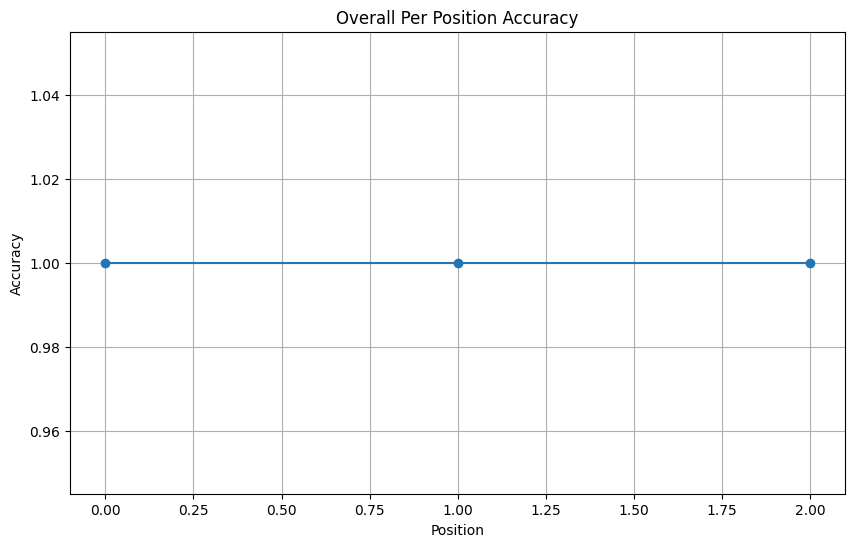

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
└───────────────────────────────┴───────────────────────────────┘

In [101]:
# test on pure fact, make sure it acheives 100% accuracy
trainer.test(model=lit_model, dataloaders=train_dl_fact_test)
reverse_vocab_map = {idx: vocab for vocab, idx in vocab_map.items()}



### "finetune" on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness


In [102]:
# finetune on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness

trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=validation_dataloaders)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 415 K 
----------------------------------------
415 K     Trainable params
0         Non-trainable params
415 K     Total params
1.661     Total estimated model params size (MB)


num decayed parameter tensors: 11, with 411,904 parameters
num non-decayed parameter tensors: 17, with 3,391 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

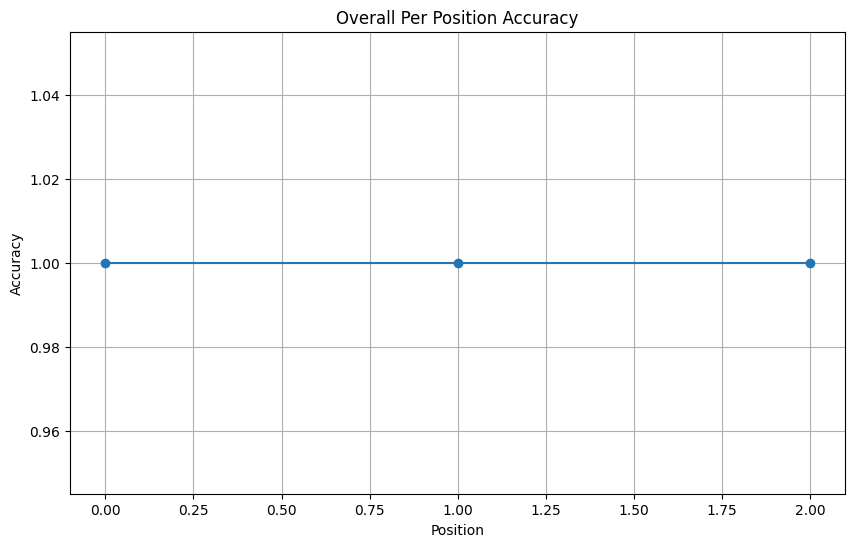

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
└───────────────────────────────┴───────────────────────────────┘

In [103]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}

# model performance on the pure fact pretraining set
trainer.test(model=lit_model, dataloaders=train_dl_fact_test)
# model performance on the validation set
lit_model.mismatched_sequences.clear()


## Test on counterfactual context

In [104]:
def decode_sequence(seq, reverse_vocab_map):
    return ' '.join([reverse_vocab_map[idx] for idx in seq])

def mismatch_seq_print(mismatch, reverse_vocab_map, max_examples=3):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}\n")

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

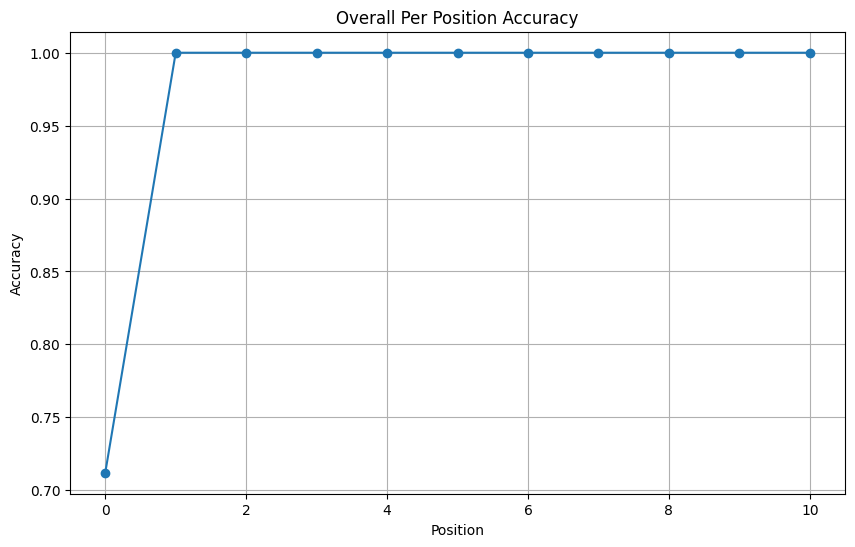

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.9738103747367859       │
│     test_overall_seq_acc      │         0.7119140625          │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N49 R4 N7 <SEP> </CTX> <QUERY> N49 R4
Predicted: N12 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N35 R2 N47 <SEP> </CTX> <QUERY> N35 R2
Predicted: N6 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N47 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N25 R1 N3 <SEP> </CTX> <QUERY> N25 R1
Predicted: N45 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N3 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Testing: |          | 0/? [00:00<?, ?it/s]

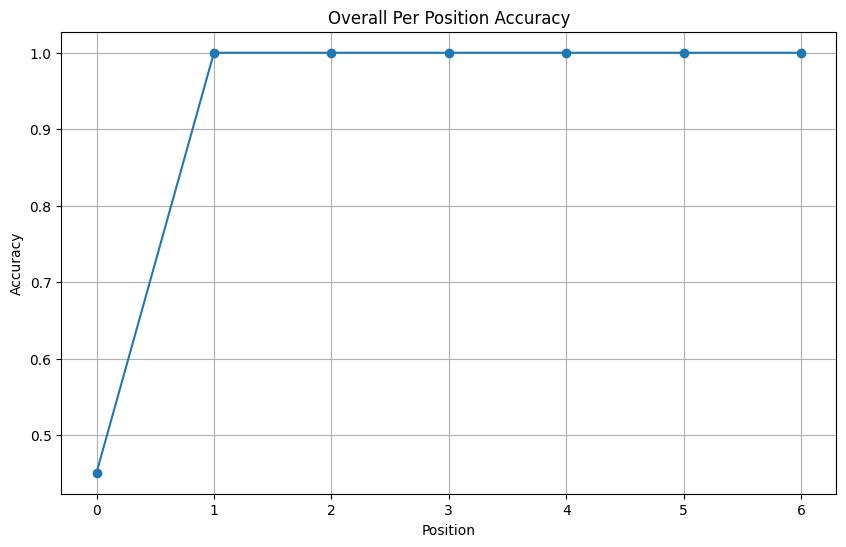

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.9215959906578064       │
│     test_overall_seq_acc      │          0.451171875          │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N0 R1 N18 <SEP> N4 R4 N3 <SEP> </CTX> <QUERY> N4 R4
Predicted: N46 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N3 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N4 R0 N2 <SEP> N0 R2 N30 <SEP> </CTX> <QUERY> N0 R2
Predicted: N47 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N30 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N31 R2 N12 <SEP> N29 R3 N23 <SEP> </CTX> <QUERY> N29 R3
Predicted: N34 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N23 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>



Testing: |          | 0/? [00:00<?, ?it/s]

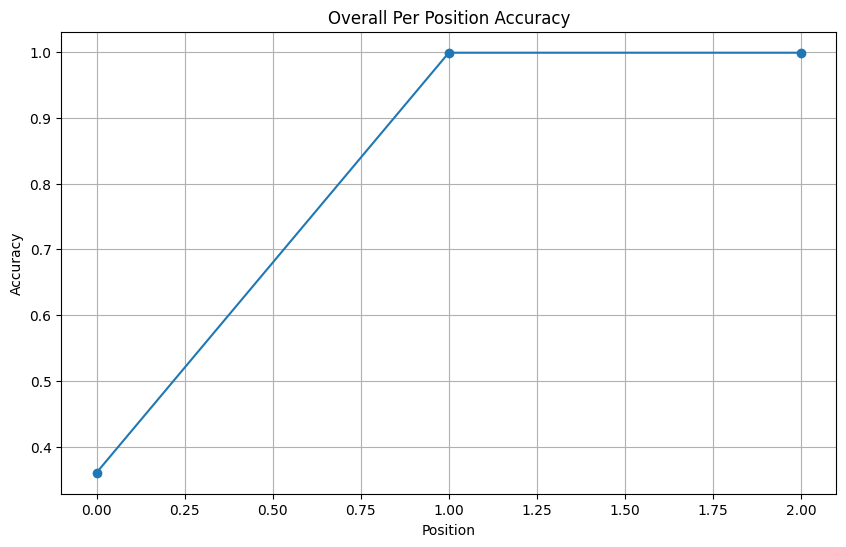

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │         0.7861328125          │
│     test_overall_seq_acc      │         0.3603515625          │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N17 R1 N43 <SEP> N42 R2 N25 <SEP> N26 R4 N28 <SEP> </CTX> <QUERY> N42 R2
Predicted: N2 </QUERY> <EOS>
Target: N25 </QUERY> <EOS>

Input: <CTX> N16 R2 N6 <SEP> N47 R0 N29 <SEP> N24 R3 N23 <SEP> </CTX> <QUERY> N47 R0
Predicted: N13 </QUERY> <EOS>
Target: N29 </QUERY> <EOS>

Input: <CTX> N44 R4 N25 <SEP> N31 R2 N12 <SEP> N21 R2 N13 <SEP> </CTX> <QUERY> N44 R4
Predicted: N5 </QUERY> <EOS>
Target: N25 </QUERY> <EOS>



In [105]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()



## Test on Robustness 

Testing: |          | 0/? [00:00<?, ?it/s]

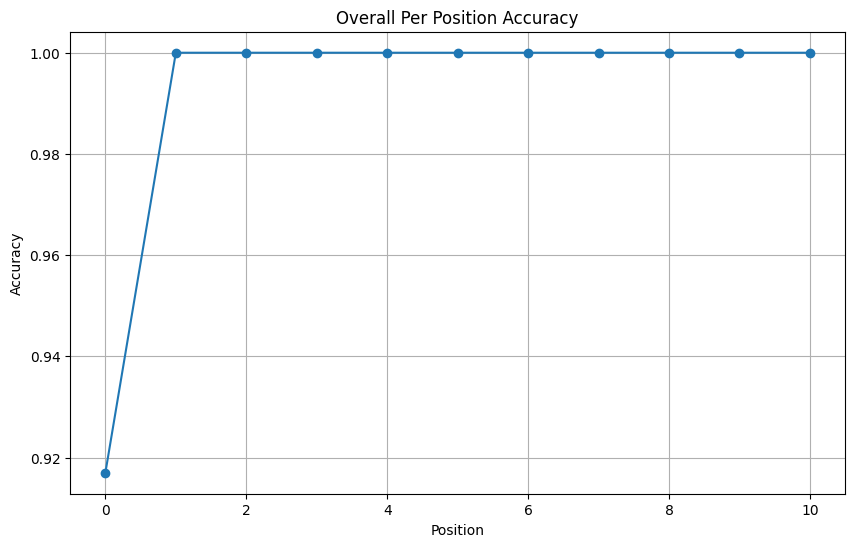

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.9924538135528564       │
│     test_overall_seq_acc      │         0.9169921875          │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N20 R1 N39 <SEP> </CTX> <QUERY> N15 R1
Predicted: N39 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N29 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N10 R4 N18 <SEP> </CTX> <QUERY> N35 R2
Predicted: N40 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N6 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N38 R4 N36 <SEP> </CTX> <QUERY> N1 R4
Predicted: N36 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N22 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N30 R0 N3 <SEP> </CTX> <QUERY> N10 R0
Predicted: N3 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N37 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N2 R4 N42 <SEP> </CTX> <QUERY> N1 R4
Predicted: N42 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N22 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <

Testing: |          | 0/? [00:00<?, ?it/s]

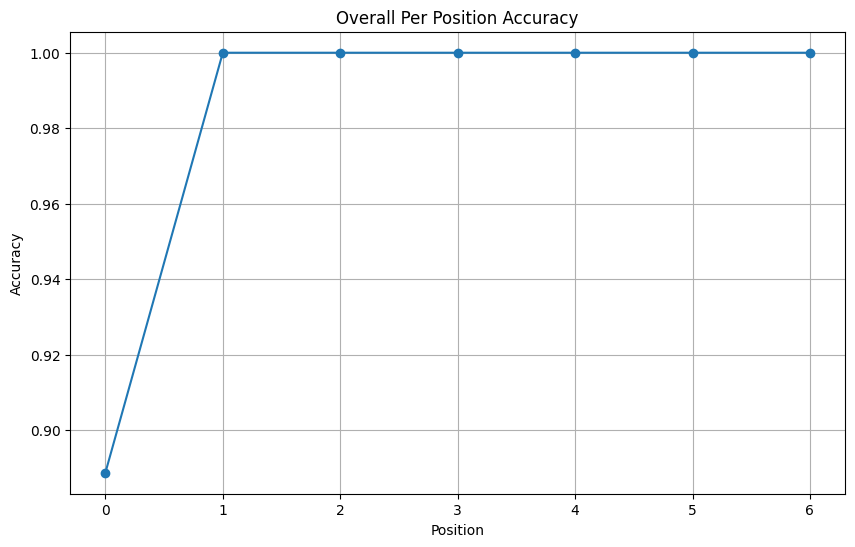

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.9840959906578064       │
│     test_overall_seq_acc      │          0.888671875          │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N35 R4 N16 <SEP> N33 R1 N49 <SEP> </CTX> <QUERY> N43 R2
Predicted: N45 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N1 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N17 R1 N43 <SEP> N46 R3 N43 <SEP> </CTX> <QUERY> N43 R1
Predicted: N43 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N31 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N12 R1 N21 <SEP> N36 R2 N12 <SEP> </CTX> <QUERY> N18 R0
Predicted: N19 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N4 R1 N32 <SEP> N41 R4 N19 <SEP> </CTX> <QUERY> N28 R1
Predicted: N32 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N9 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N15 R1 N29 <SEP> N44 R3 N20 <SEP> </CTX> <QUERY> N13 R3
Predicted: N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N21 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N36 R2 N12 <SEP> N20 R3 N49 <SEP> </CTX> <QUERY> N42 R3
Predicted: N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target

Testing: |          | 0/? [00:00<?, ?it/s]

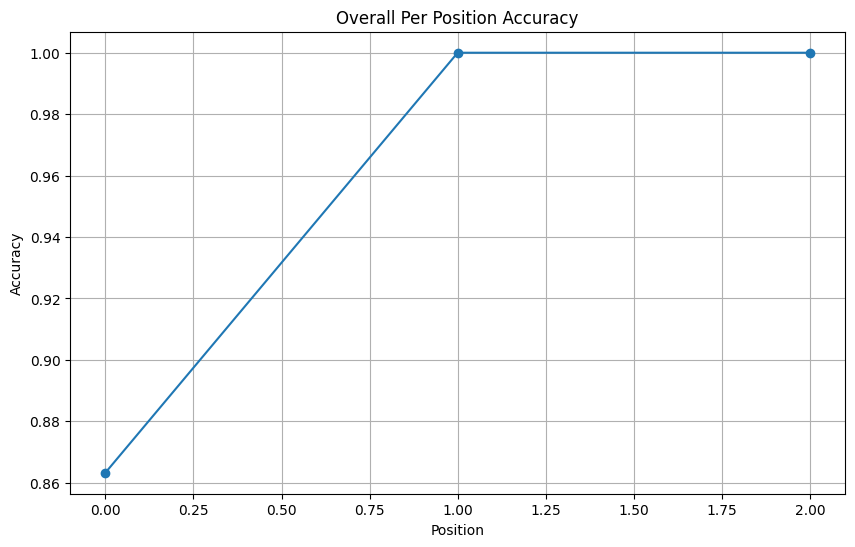

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test_overall_per_pos_acc_mean │      0.9544270634651184       │
│     test_overall_seq_acc      │          0.86328125           │
└───────────────────────────────┴───────────────────────────────┘

Input: <CTX> N46 R1 N28 <SEP> N46 R1 N28 <SEP> N8 R2 N26 <SEP> </CTX> <QUERY> N20 R1
Predicted: N28 </QUERY> <EOS>
Target: N39 </QUERY> <EOS>

Input: <CTX> N24 R3 N23 <SEP> N34 R4 N17 <SEP> N35 R4 N16 <SEP> </CTX> <QUERY> N37 R1
Predicted: N44 </QUERY> <EOS>
Target: N40 </QUERY> <EOS>

Input: <CTX> N23 R3 N4 <SEP> N20 R1 N39 <SEP> N26 R3 N23 <SEP> </CTX> <QUERY> N1 R1
Predicted: N39 </QUERY> <EOS>
Target: N38 </QUERY> <EOS>

Input: <CTX> N6 R0 N7 <SEP> N21 R2 N13 <SEP> N44 R4 N5 <SEP> </CTX> <QUERY> N11 R3
Predicted: N23 </QUERY> <EOS>
Target: N2 </QUERY> <EOS>

Input: <CTX> N46 R3 N43 <SEP> N47 R4 N3 <SEP> N33 R3 N21 <SEP> </CTX> <QUERY> N2 R3
Predicted: N21 </QUERY> <EOS>
Target: N42 </QUERY> <EOS>

Input: <CTX> N44 R3 N20 <SEP> N1 R4 N22 <SEP> N28 R2 N38 <SEP> </CTX> <QUERY> N11 R2
Predicted: N2 </QUERY> <EOS>
Target: N31 </QUERY> <EOS>



In [106]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map,max_examples=6)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map, max_examples=6)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map, max_examples=6)

